<a href="https://colab.research.google.com/github/hellojohnkim/mmai894/blob/main/Pump_it_up_XGB_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, atpe
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##Pump It Up Faulty Water Pump Prediction Model

#Data Loading

In [10]:
# Specifying the datasets file paths
training_set_values_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/training_set_values.csv'
training_set_labels_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/training_set_label.csv'
test_set_file_path = '/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/data/test_set.csv'

# Loading the datasets
features_df = pd.read_csv(training_set_values_file_path)
labels_df = pd.read_csv(training_set_labels_file_path)
test = pd.read_csv(test_set_file_path)

# Displaying the first few rows of the datasets
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Pre-Processing

In [12]:
# Merge the data on id
data_df = features_df.merge(labels_df, on='id')

# Encode 'construction_year' as a cyclical feature
max_year = data_df['construction_year'].max()
data_df['construction_year_sin'] = np.sin(2 * np.pi * data_df['construction_year'] / max_year)
data_df['construction_year_cos'] = np.cos(2 * np.pi * data_df['construction_year'] / max_year)

# Calculate 'age'
current_year = datetime.now().year
data_df['age'] = current_year - data_df['construction_year']
data_df['age'].replace({current_year: np.nan}, inplace=True)  # Replace invalid ages with NaN
data_df.drop(['construction_year'], axis=1, inplace=True)  # Drop original 'construction_year'

# Date feature transformation
data_df['date_recorded'] = pd.to_datetime(data_df['date_recorded'])
data_df['year_recorded'] = data_df['date_recorded'].dt.year
data_df['month_recorded'] = data_df['date_recorded'].dt.month
data_df['day_recorded'] = data_df['date_recorded'].dt.day
data_df['days_since_recorded'] = (data_df['date_recorded'] - data_df['date_recorded'].min()).dt.days
data_df.drop('date_recorded', axis=1, inplace=True)

# Handling categorical variables
categorical_cols = data_df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols.remove('status_group')
categorical_cols.extend(['region_code', 'district_code'])  # Include region and district codes as categorical

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

X = data_df.drop('status_group', axis=1)
y = data_df['status_group']

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(eval_metric='mlogloss', n_jobs=-1))
])

X.drop('id', axis=1, inplace=True)  # Drop 'id' column

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)



### Data Preprocessing Report

#### 1. One-Hot Encoding of Labels
- **Variable Affected**: `status_group`
- **Reason for Preprocessing**: To convert categorical labels into a numerical format suitable for machine learning models. Essential for classification tasks.
- **Applied Strategy**: One-hot encoding, resulting in an array with a shape corresponding to the number of samples and label categories.

#### 2. Feature Engineering - 'Age'
- **Variable Affected**: `construction_year`
- **Reason for Preprocessing**: To derive more meaningful information from the year of construction by calculating the age of the waterpoints.
- **Applied Strategy**: Calculated 'age' as the difference between the current year and the construction year. Replaced invalid ages (where construction year is the current year) with NaN.

#### 3. Dropping Columns
- **Variables Affected**: `id`, `wpt_name`, `funder`, `installer`, `construction_year`, `extraction_type_group`, `payment_type`, `quality_group`, `quantity_group`, `source_type`, `recorded_by`
- **Reason for Preprocessing**: To remove features with high cardinality, low predictive power, redundant information, or those that are identifiers with no predictive value.
- **Applied Strategy**: These columns were dropped from the dataset.

#### 4. Encoding Date Variables
- **Variable Affected**: `date_recorded`
- **Reason for Preprocessing**: To transform the date into a more usable format for modeling.
- **Applied Strategy**: Extracted the year from `date_recorded` and created a new feature `year_recorded`. The original `date_recorded` column was then dropped.

#### 5. Handling Categorical Variables
- **Variables Affected**: All categorical columns including `region_code` and `district_code`
- **Reason for Preprocessing**: To convert categorical variables into a numeric format that machine learning algorithms can interpret.
- **Applied Strategy**: Converted `region_code` and `district_code` to strings. Applied Label Encoding to all categorical variables, including combined categories from training and test sets to handle unseen categories in the test data.

#### 6. Normalization of Numeric Features
- **Variables Affected**: All numeric columns
- **Reason for Preprocessing**: To scale numeric features to a uniform range, important for algorithms that are sensitive to the scale of input data.
- **Applied Strategy**: Used `MinMaxScaler` within a pipeline to normalize numeric features.

#### 7. Data Transformation and Splitting
- **Reason for Preprocessing**: To prepare the data for model training and evaluation.
- **Applied Strategy**: Transformed the datasets using a ColumnTransformer and split the data into training and validation sets using train_test_split.

This report reflects the preprocessing steps taken in your code, providing a clear understanding of the transformations and rationale behind each step for anyone reviewing the process.

#XGB Baseline Model

#XGB Baseline + Hyperparameter Tuning using Hyperopt

In [ ]:
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'min_child_weight': hp.uniform('min_child_weight', 0, 10),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 1.0, 4.0),
}

def objective(params):
    pipeline.set_params(xgb__learning_rate=params['learning_rate'],
                        xgb__max_depth=params['max_depth'],
                        xgb__n_estimators=params['n_estimators'],
                        xgb__subsample=params['subsample'],
                        xgb__colsample_bytree=params['colsample_bytree'],
                        xgb__gamma=params['gamma'],
                        xgb__min_child_weight=params['min_child_weight'],
                        xgb__reg_alpha=params['reg_alpha'],
                        xgb__reg_lambda=params['reg_lambda'])
    score = cross_val_score(pipeline, X, y, cv=6, scoring='f1_weighted').mean()
    return {'loss': -score, 'status': STATUS_OK}

trials = Trials()
best_params = fmin(fn=objective, space=space, algo=atpe.suggest, max_evals=60, trials=trials)

print("Best parameters:", best_params)

 75%|███████▌  | 45/60 [8:20:53<6:07:30, 1470.03s/trial, best loss: -0.7978066329340706]

In [ ]:
best_params = study.best_trial.params
optimized_model = XGBClassifier(**best_params, random_state=42)
optimized_model.fit(X_train, y_train_labels)

y_val_pred = optimized_model.predict(X_val)
accuracy_val = accuracy_score(y_val_labels, y_val_pred)
print(f"Optimized Validation Accuracy: {accuracy_val:.4f}")


Optimized Validation Accuracy: 0.8130


### Hyperparameter Optimization and Performance Analysis of XGBoost Model using Optuna

#### Hyperparameter Optimization with Optuna

- **Objective**: To enhance the XGBoost model's performance by optimizing its hyperparameters using Optuna.
- **Method**: Utilized Optuna to systematically search for the best combination of hyperparameters. Conducted 20 trials to find the optimal settings.
- **Best Hyperparameters Identified**:
  - `n_estimators`: 274 (Number of boosted trees to fit)
  - `max_depth`: 11 (Maximum tree depth)
  - `learning_rate`: 0.06356 (Boosting learning rate)
  - `subsample`: 0.7102 (Subsample ratio of the training instances)
  - `colsample_bytree`: 0.8771 (Subsample ratio of columns when constructing each tree)
  - `gamma`: 1.42e-07 (Minimum loss reduction required to make a further partition)
  - `min_child_weight`: 1 (Minimum sum of instance weight needed in a child)
- **Optuna Trial Result**: The best trial achieved an accuracy of 81.30% on the validation set.

#### Model Performance with Optimized Parameters

- **Optimized Model Configuration**: Used the best parameters obtained from Optuna.
- **Optimized Validation Accuracy**: Achieved 81.30%, a notable improvement over the baseline model.

#### Baseline Model Performance

- **Configuration**: Used predefined hyperparameters (n_estimators: 1000, learning_rate: 0.1, etc.).
- **Validation Accuracy**: 80.61%.

#### Classification Report of Baseline Model

| Class | Precision | Recall  | F1-Score | Support    |
|-------|-----------|---------|----------|------------|
| 0     | 0.8033    | 0.8936  | 0.8460   | 6457.000   |
| 1     | 0.5575    | 0.3020  | 0.3918   |  851.000   |
| 2     | 0.8378    | 0.7762  | 0.8059   | 4572.000   |

- **Overall Performance**:
  - Macro Avg Precision: 73.29%
  - Weighted Avg Precision: 79.90%
  - Macro Avg F1-Score: 68.12%
  - Weighted Avg F1-Score: 79.80%

#### Analysis and Observations

- **Classification Performance**:
  - The baseline model showed variable performance across different classes.
  - Class 0 exhibited the highest precision and recall, while Class 1 had the lowest, indicating potential challenges in class imbalance.
  - The disparity in scores suggests exploring class-specific strategies and addressing class imbalance.
  - The difference between macro and weighted averages in the baseline model highlighted the impact of class imbalance on overall performance.
- **Next Steps**:
  - Experiment with deep learning methods and experiments
  - Further tuning or feature engineering could be explored to improve the model's ability to generalize across all classes.

#### Conclusion

Optuna's hyperparameter optimization proved beneficial, enhancing the XGBoost model's performance. The analysis underscores the importance of tuning and the need to address class-specific issues for a more balanced and effective model.

#Feature Importance (not required)

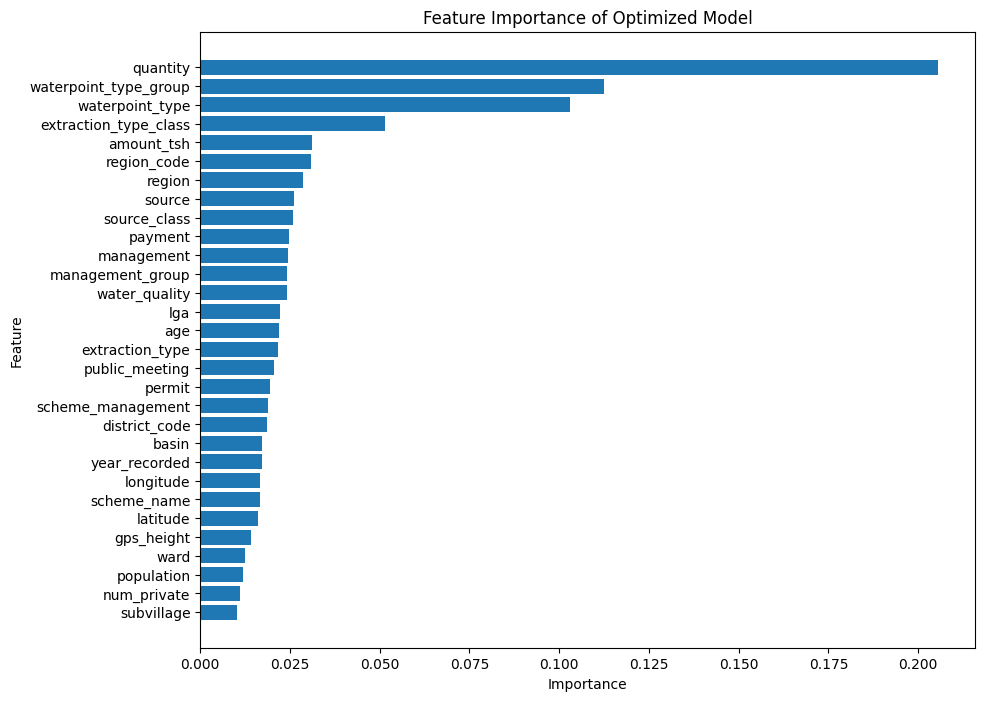

In [ ]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = optimized_model.feature_importances_

# Get column names from the training values dataset
feature_names = training_values.columns

# Create a DataFrame for easy visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Optimized Model')
plt.gca().invert_yaxis()
plt.show()


#Creating submission file

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
from datetime import datetime

# Load the datasets
training_values = pd.read_csv(training_set_values_file_path)
training_labels = pd.read_csv(training_set_labels_file_path)
test_values = pd.read_csv(test_set_file_path)

# Store test IDs for later use
test_ids = test_values['id'].copy()

# One-Hot Encoding of Labels
encoder = OneHotEncoder(sparse=False)
encoded_labels = encoder.fit_transform(training_labels[['status_group']])

# Calculate 'age'
current_year = datetime.now().year
for dataset in [training_values, test_values]:
    dataset['age'] = current_year - dataset['construction_year']
    dataset['age'].replace({current_year: np.nan}, inplace=True)

# Columns to Drop
columns_to_drop = ['id', 'wpt_name', 'funder', 'installer', 'construction_year',
                   'extraction_type_group', 'payment_type', 'quality_group',
                   'quantity_group', 'source_type', 'recorded_by']
training_values.drop(columns=columns_to_drop, inplace=True)
test_values.drop(columns=columns_to_drop, inplace=True)


# Handling 'date_recorded'
for dataset in [training_values, test_values]:
    dataset['year_recorded'] = pd.to_datetime(dataset['date_recorded']).dt.year
    dataset.drop(columns=['date_recorded'], inplace=True)

# Convert region_code and district_code to string
for dataset in [training_values, test_values]:
    dataset['region_code'] = dataset['region_code'].astype(str)
    dataset['district_code'] = dataset['district_code'].astype(str)

# Update categorical columns list
categorical_columns = training_values.select_dtypes(include=['object', 'bool']).columns.tolist()

# Adjusting Label Encoding to handle unseen categories in test data
for col in categorical_columns:
    combined_categories = pd.concat([training_values[col], test_values[col]], axis=0).astype(str).unique()
    le = LabelEncoder().fit(combined_categories)
    training_values[col] = le.transform(training_values[col].astype(str))
    test_values[col] = le.transform(test_values[col].astype(str))

# Normalization of Numeric Features
numeric_columns = training_values.select_dtypes(include=[np.number]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns)
    ],
    remainder='passthrough'  # Keep other columns unchanged
)


# Making predictions on the test set
test_predictions = optimized_model.predict(X_test_processed)

# label names in the original dataset are 'functional', 'non functional', and 'functional needs repair'
label_names = ['functional', 'non functional', 'functional needs repair']

# Transform the class indices (0, 1, 2) back to original class names
test_predictions_labels = [label_names[index] for index in test_predictions]

# Creating a DataFrame for submission
submission_df = pd.DataFrame({
    'id': test_ids,  # Use stored test IDs
    'status_group': test_predictions_labels
})

# Display the first few rows of the DataFrame
print(submission_df.head())


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


      id             status_group
0  50785  functional needs repair
1  51630               functional
2  17168               functional
3  45559  functional needs repair
4  49871               functional


In [ ]:

# Saving the DataFrame to a CSV file
submission_df.to_csv('/content/drive/MyDrive/MMAI_Group/894_team/DrivenData_Competition/notebooks/John/SubmissionFormat.csv', index=False)